In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [2]:
IS_COLAB = 1
MODEL_NAME = 'model330early'

In [3]:
if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip '/content/drive/MyDrive/Train_24_33hz_6classes/24_33hz_6_classes.zip'

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: downsample_24_train_data/PAB/217-63425.png  
  inflating: downsample_24_train_data/PAB/107-40273.png  
  inflating: downsample_24_train_data/PAB/217-44517.png  
  inflating: downsample_24_train_data/PAB/217-61907.png  
  inflating: downsample_24_train_data/PAB/217-21052.png  
  inflating: downsample_24_train_data/PAB/107-47181.png  
  inflating: downsample_24_train_data/PAB/217-4370.png  
  inflating: downsample_24_train_data/PAB/217-28419.png  
  inflating: downsample_24_train_data/PAB/107-3269.png  
  inflating: downsample_24_train_data/PAB/107-59385.png  
  inflating: downsample_24_train_data/PAB/217-472.png  
  inflating: downsample_24_train_data/PAB/107-51555.png  
  inflating: downsample_24_train_data/PAB/217-61264.png  
  inflating: downsample_24_train_data/PAB/217-655.png  
  inflating: downsample_24_train_data/PAB/217-1580.png  
  inflating: downsample_24_train_data/PAB/107-35219.png  
  inflating: downsampl

In [5]:
# Load data from CSV files
train_data = pd.read_csv("train.csv")
val_data = pd.read_csv("val.csv")
test_data = pd.read_csv("test.csv")

In [6]:
test_data['label'].value_counts()

N      2194
L       551
R       499
PAB     405
A        61
V        52
Name: label, dtype: int64

In [7]:
label_mapping = {'N': 0, 'V': 1, 'PAB': 2, 'R': 3, 'L': 4, 'A': 5}
train_data = train_data.replace({'label': label_mapping})
val_data = val_data.replace({'label': label_mapping})
test_data = test_data.replace({'label': label_mapping})

# Pie chart

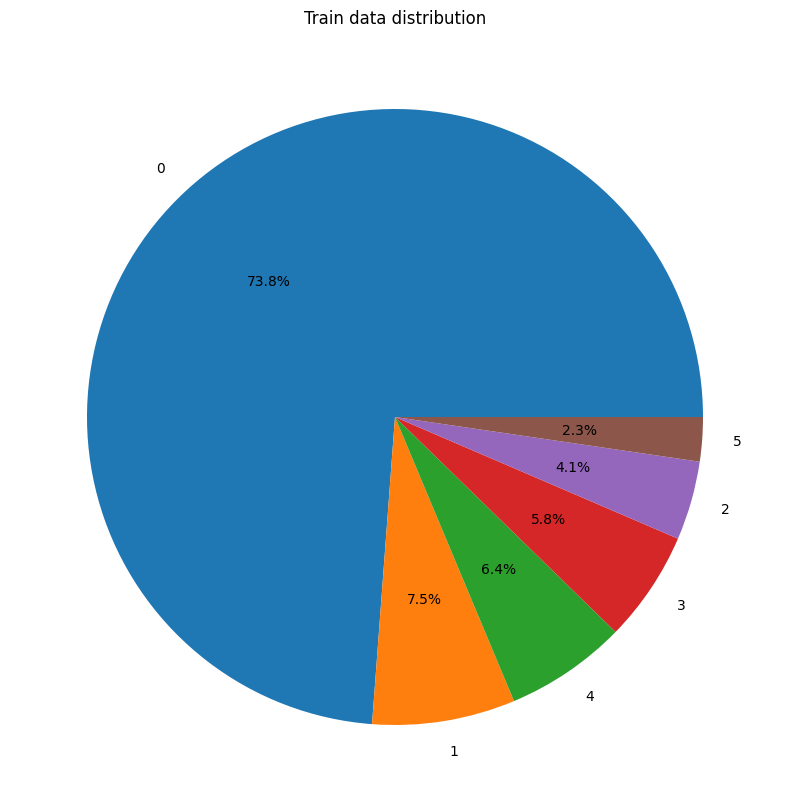

In [8]:
# draw pie chart of train data
train_data['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10, 10))
plt.title('Train data distribution')
plt.ylabel('')
plt.show()

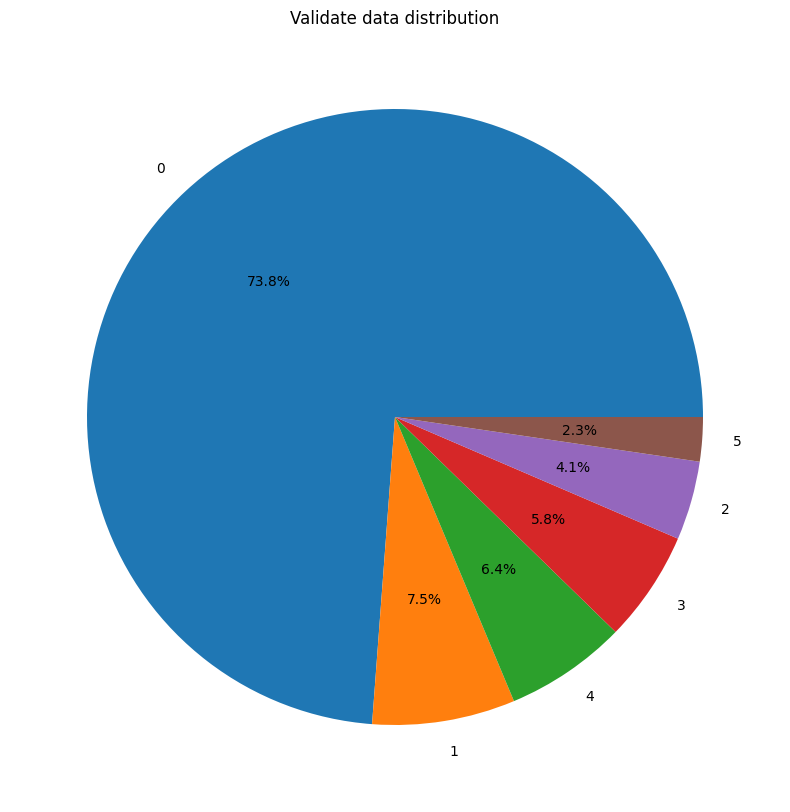

In [9]:
# draw pie chart of train data
val_data['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10, 10))
plt.title('Validate data distribution')
plt.ylabel('')
plt.show()

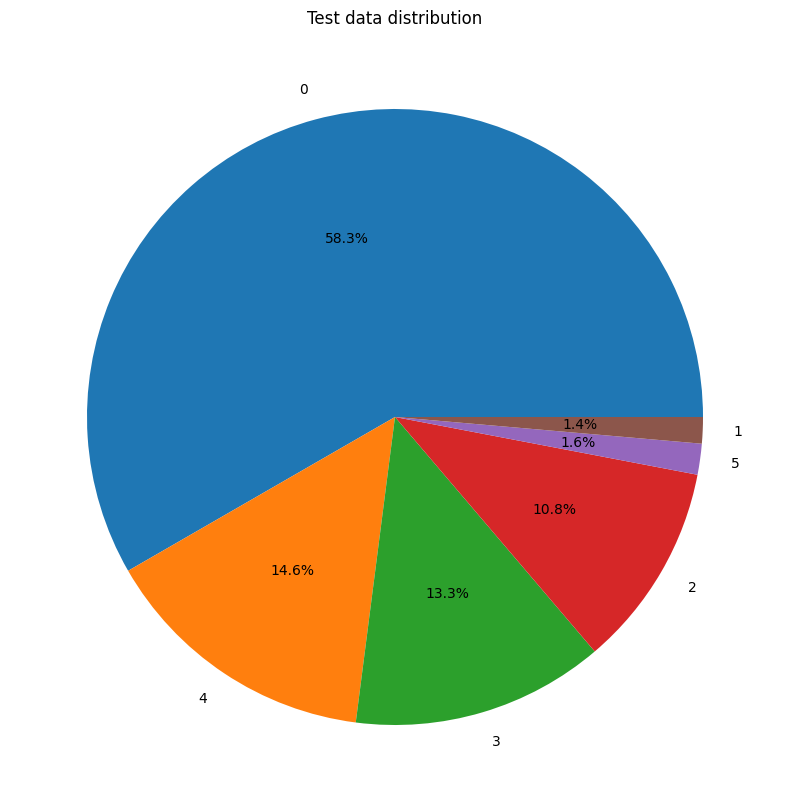

In [10]:
# draw pie chart of train data
test_data['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10, 10))
plt.title('Test data distribution')
plt.ylabel('')
plt.show()

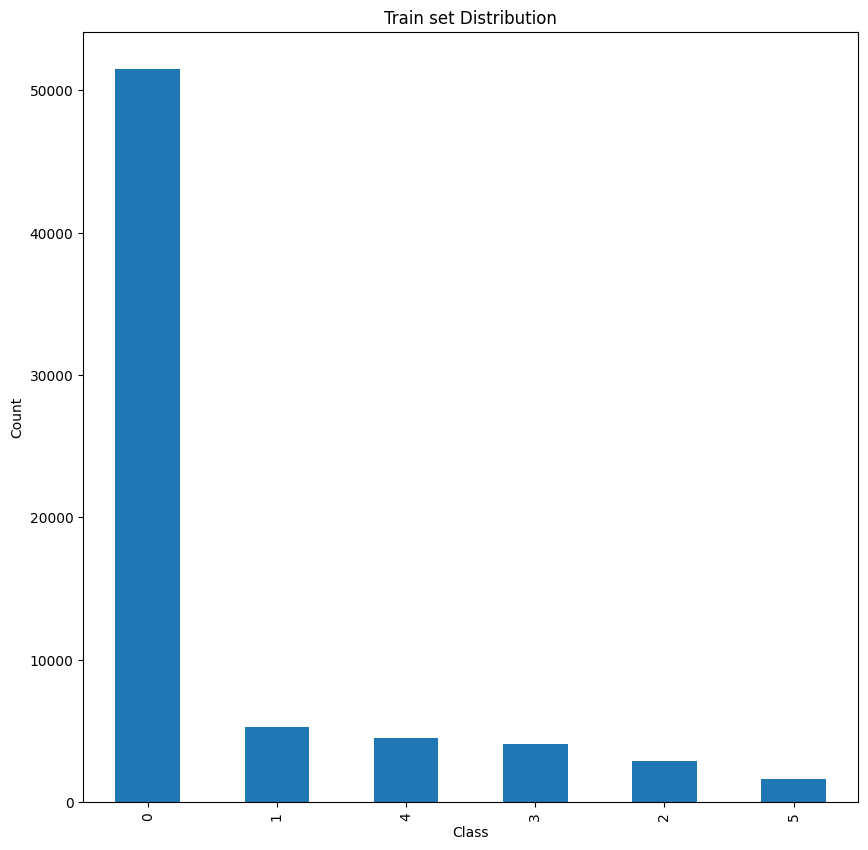

In [11]:
# plot bar chart of each class count and add number of samples in each class
train_data['label'].value_counts().plot(kind='bar', figsize=(10, 10))   
# add title and x, y labels
plt.title('Train set Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


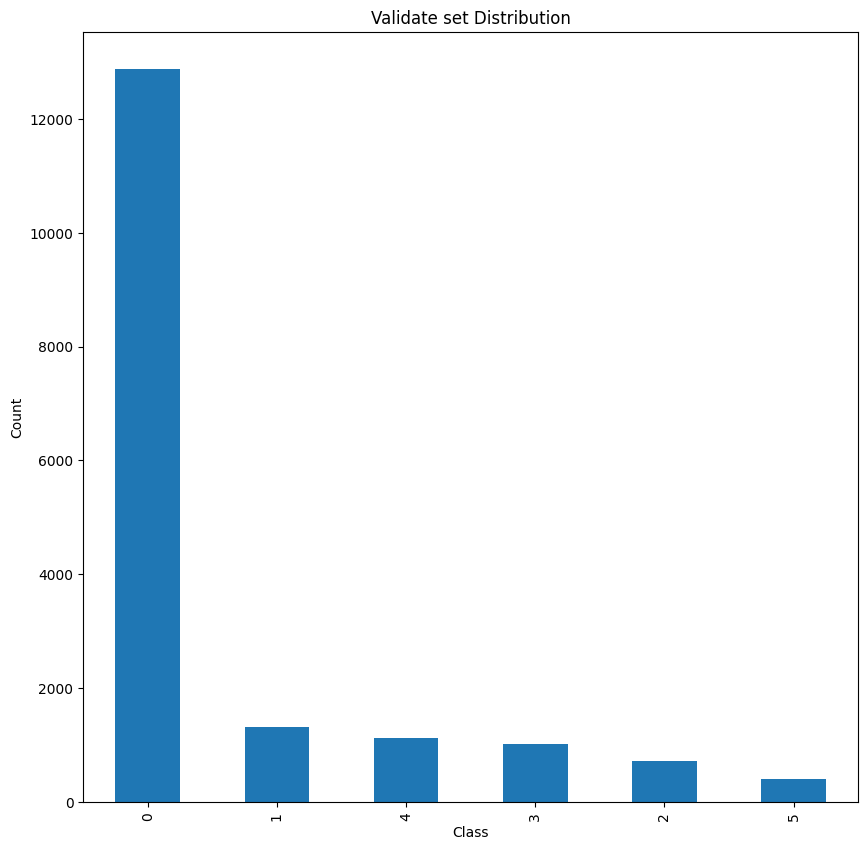

In [12]:
# plot bar chart of each class count and add number of samples in each class
val_data['label'].value_counts().plot(kind='bar', figsize=(10, 10))   
# add title and x, y labels
plt.title('Validate set Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


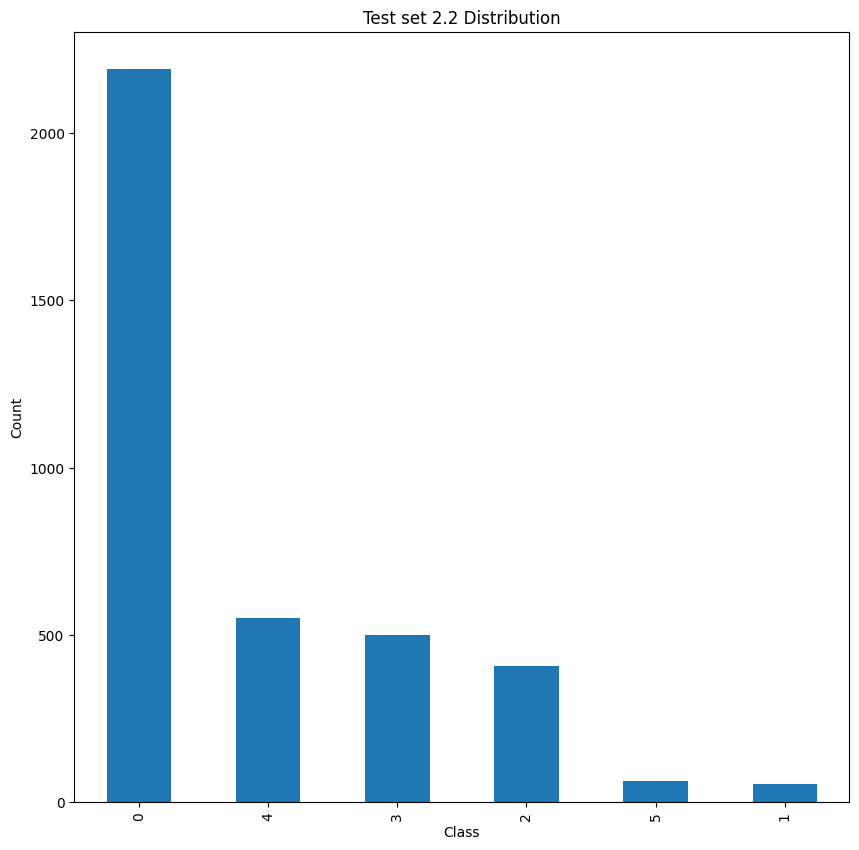

In [13]:
# plot bar chart of each class count and add number of samples in each class
test_data['label'].value_counts().plot(kind='bar', figsize=(10, 10))   
# add title and x, y labels
plt.title('Test set 2.2 Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [14]:
# plot number of unique value in label column of newtrain.csv
train_data['label'].value_counts()

0    51537
1     5238
4     4463
3     4071
2     2893
5     1620
Name: label, dtype: int64

In [15]:
val_data['label'].value_counts()

0    12884
1     1309
4     1116
3     1018
2      723
5      405
Name: label, dtype: int64

In [16]:
test_data['label'].value_counts()


0    2194
4     551
3     499
2     405
5      61
1      52
Name: label, dtype: int64

In [17]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, df, num_classes, shuffle=False, batch_size = 10):
        self.indices = None
        self.length = None
        self.df: pd.DataFrame = df
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.__len__()
        self.on_epoch_end()

    def __len__(self):
        self.length = len(self.df) // self.batch_size
        if len(self.df) % self.batch_size != 0:
            self.length +=1
        return self.length

    def __getitem__(self, idx):
        X = []
        y = []
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        if idx == self.length-1:
            indices = self.indices[idx*self.batch_size:]
        for i, data_index in enumerate(indices):
            img_path = self.df.loc[data_index, 'path']
            img = load_img(img_path, color_mode="grayscale", target_size=(128, 128))
            img = img_to_array(img) / 255.0
            label = to_categorical(self.df.loc[data_index, 'label'], self.num_classes)

            X.append(img)
            y.append(label)
        X = np.stack(X)
        y = np.stack(y)
        return X, y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)


In [18]:
BATCH_SIZE = 256 if IS_COLAB else 10

In [19]:
train_gen = DataGenerator(df=train_data, batch_size=BATCH_SIZE, shuffle=True, num_classes=6)
val_gen = DataGenerator(df=val_data, batch_size=BATCH_SIZE, shuffle=False, num_classes=6)
test_gen = DataGenerator(df=test_data, batch_size=BATCH_SIZE, shuffle=False, num_classes=6)

In [20]:
import keras
from keras import layers, regularizers
# Define CNN model with dropout and L2 regularization
model = keras.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(6, activation="softmax"),
    ]
)

In [21]:

# Compile model
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [23]:
# Early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
CP_PATH = f'/content/drive/MyDrive/Train_24_33hz_6classes/checkpoint/{MODEL_NAME}' if IS_COLAB else 'tensorflow'
checkpoint = tf.keras.callbacks.ModelCheckpoint(CP_PATH, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
cb_l = [checkpoint, early_stopping]
history = model.fit(
    train_gen, validation_data=val_gen, epochs=30, callbacks=cb_l
)

Epoch 1/30
273/273 [==============================] - ETA: 0s - loss: 0.4720 - accuracy: 0.8625
Epoch 1: accuracy improved from -inf to 0.86245, saving model to /content/drive/MyDrive/Train_24_33hz_6classes/checkpoint/model330early


273/273 [==============================] - 62s 180ms/step - loss: 0.4720 - accuracy: 0.8625 - val_loss: 0.2886 - val_accuracy: 0.9154
Epoch 2/30
273/273 [==============================] - ETA: 0s - loss: 0.2599 - accuracy: 0.9230
Epoch 2: accuracy improved from 0.86245 to 0.92300, saving model to /content/drive/MyDrive/Train_24_33hz_6classes/checkpoint/model330early


273/273 [==============================] - 51s 186ms/step - loss: 0.2599 - accuracy: 0.9230 - val_loss: 0.2352 - val_accuracy: 0.9270
Epoch 3/30
273/273 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9351
Epoch 3: accuracy improved from 0.92300 to 0.93512, saving model to /content/drive/MyDrive/Train_24_33hz_6classes/checkpoint/model330early


273/273 [==============================] - 47s 172ms/step - loss: 0.2124 - accuracy: 0.9351 - val_loss: 0.2255 - val_accuracy: 0.9333
Epoch 4/30
273/273 [==============================] - ETA: 0s - loss: 0.1822 - accuracy: 0.9431
Epoch 4: accuracy improved from 0.93512 to 0.94310, saving model to /content/drive/MyDrive/Train_24_33hz_6classes/checkpoint/model330early


273/273 [==============================] - 47s 173ms/step - loss: 0.1822 - accuracy: 0.9431 - val_loss: 0.2124 - val_accuracy: 0.9354
Epoch 5/30
273/273 [==============================] - ETA: 0s - loss: 0.1616 - accuracy: 0.9481
Epoch 5: accuracy improved from 0.94310 to 0.94813, saving model to /content/drive/MyDrive/Train_24_33hz_6classes/checkpoint/model330early


273/273 [==============================] - 47s 172ms/step - loss: 0.1616 - accuracy: 0.9481 - val_loss: 0.2128 - val_accuracy: 0.9378
Epoch 6/30
273/273 [==============================] - ETA: 0s - loss: 0.1426 - accuracy: 0.9539
Epoch 6: accuracy improved from 0.94813 to 0.95385, saving model to /content/drive/MyDrive/Train_24_33hz_6classes/checkpoint/model330early


273/273 [==============================] - 47s 173ms/step - loss: 0.1426 - accuracy: 0.9539 - val_loss: 0.2072 - val_accuracy: 0.9389
Epoch 7/30
273/273 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.9576
Epoch 7: accuracy improved from 0.95385 to 0.95764, saving model to /content/drive/MyDrive/Train_24_33hz_6classes/checkpoint/model330early


273/273 [==============================] - 47s 172ms/step - loss: 0.1281 - accuracy: 0.9576 - val_loss: 0.2130 - val_accuracy: 0.9383
Epoch 8/30
273/273 [==============================] - ETA: 0s - loss: 0.1129 - accuracy: 0.9616
Epoch 8: accuracy improved from 0.95764 to 0.96163, saving model to /content/drive/MyDrive/Train_24_33hz_6classes/checkpoint/model330early


273/273 [==============================] - 50s 181ms/step - loss: 0.1129 - accuracy: 0.9616 - val_loss: 0.2267 - val_accuracy: 0.9385
Epoch 9/30
273/273 [==============================] - ETA: 0s - loss: 0.0995 - accuracy: 0.9666
Epoch 9: accuracy improved from 0.96163 to 0.96659, saving model to /content/drive/MyDrive/Train_24_33hz_6classes/checkpoint/model330early


273/273 [==============================] - 47s 173ms/step - loss: 0.0995 - accuracy: 0.9666 - val_loss: 0.2298 - val_accuracy: 0.9382


In [24]:
import json
import os
ECG_PATH = '/content/drive/MyDrive/Train_24_33hz_6classes/checkpoint'


In [25]:
# save history
hist_dict = history.history
json.dump(hist_dict, open(os.path.join(ECG_PATH, MODEL_NAME, 'hist.json'), 'w'))

In [26]:
model.save(os.path.join(ECG_PATH, MODEL_NAME, f'{MODEL_NAME}.h5'))

In [27]:
model = tf.keras.models.load_model(os.path.join(ECG_PATH, MODEL_NAME, f'{MODEL_NAME}.h5'))

In [28]:
# load history
hist = json.load(open(os.path.join(ECG_PATH, MODEL_NAME, 'hist.json'), 'r'))

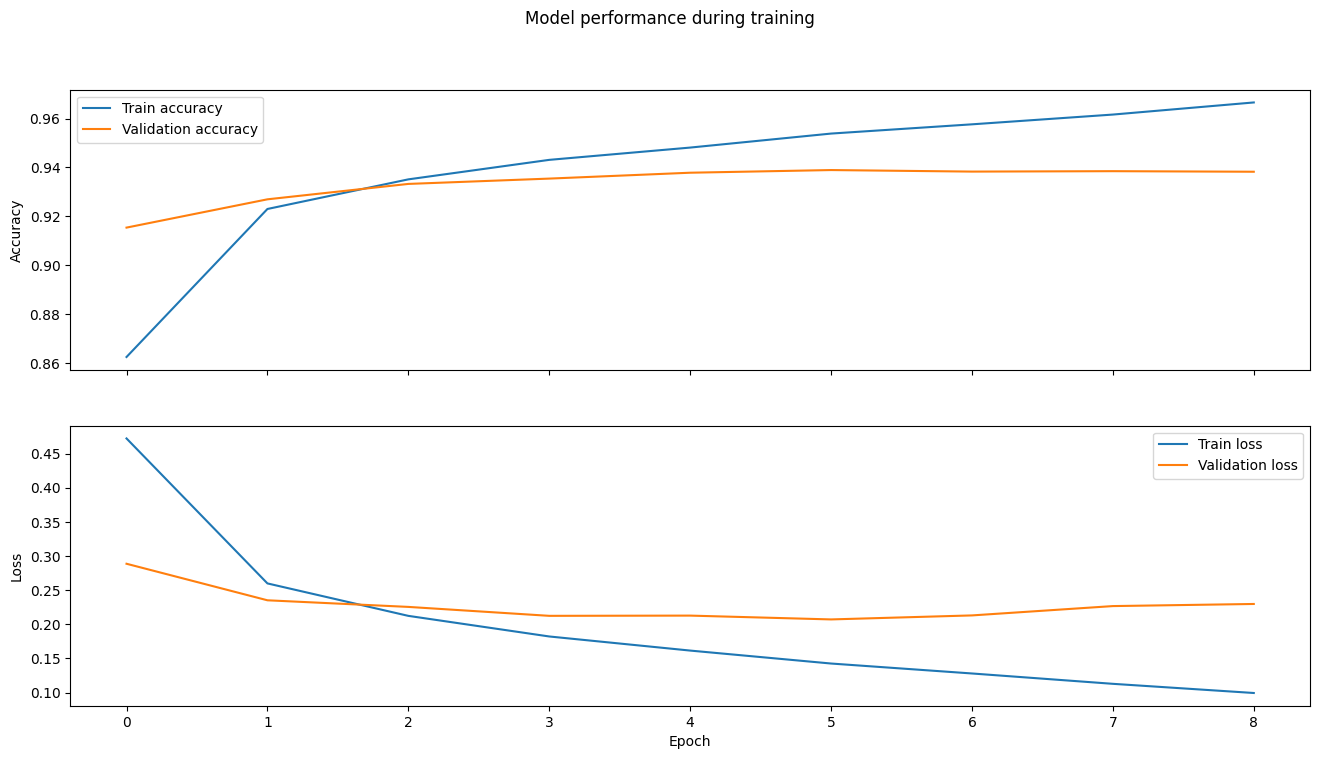

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
axes[0].plot(hist['accuracy'])
axes[0].plot(hist['val_accuracy'])
axes[0].set_ylabel('Accuracy')
axes[1].plot(hist['loss'])
axes[1].plot(hist['val_loss'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
fig.suptitle('Model performance during training')
axes[0].legend(('Train accuracy', 'Validation accuracy'))
axes[1].legend(('Train loss', 'Validation loss'))

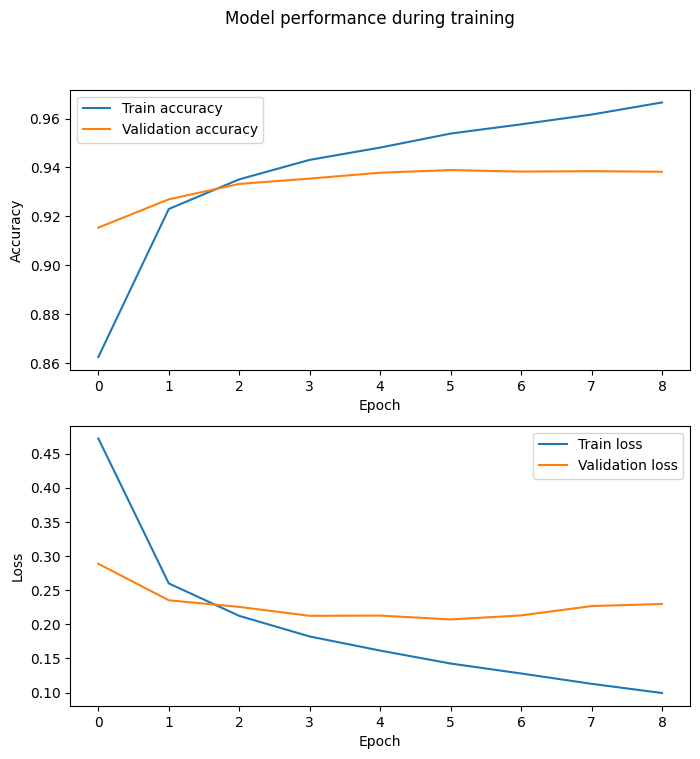

In [30]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
axes[0].plot(hist['accuracy'])
axes[0].plot(hist['val_accuracy'])
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[1].plot(hist['loss'])
axes[1].plot(hist['val_loss'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
fig.suptitle('Model performance during training')
axes[0].legend(('Train accuracy', 'Validation accuracy'))
axes[1].legend(('Train loss', 'Validation loss'))

# **Test với ảnh cắt bằng thuật toán tìm đỉnh - sai số lớn hơn 1 samples**

In [31]:
test_labels = to_categorical(test_data["label"], num_classes=6)

In [32]:
test_loss, test_acc = model.evaluate(test_gen, verbose=2)

15/15 - 3s - loss: 2.1516 - accuracy: 0.6401 - 3s/epoch - 186ms/step


In [33]:
label_mapping = {'N': 0, 'V': 1, 'PAB': 2, 'R': 3, 'L': 4, 'A': 5}

15/15 - 2s - loss: 2.1516 - accuracy: 0.6401 - 2s/epoch - 110ms/step
Test accuracy: 0.6400850415229797
Test loss: 2.1516270637512207
15/15 [==============================] - 3s 214ms/step
[[1970  168    0   23    7   26]
 [  24   14    3    0    0   11]
 [   0    1  404    0    0    0]
 [ 457   14    0   19    0    9]
 [  64  483    2    2    0    0]
 [  45   12    0    3    0    1]]


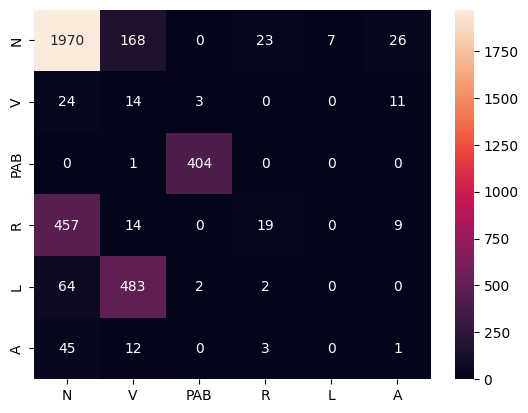

In [34]:
# test model
test_loss, test_acc = model.evaluate(test_gen, verbose=2)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

# print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)
sns.heatmap(cm, annot=True, xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(), fmt="d")
plt.show()



In [35]:
# print classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83      2194
           1       0.02      0.27      0.04        52
           2       0.99      1.00      0.99       405
           3       0.40      0.04      0.07       499
           4       0.00      0.00      0.00       551
           5       0.02      0.02      0.02        61

    accuracy                           0.64      3762
   macro avg       0.37      0.37      0.32      3762
weighted avg       0.61      0.64      0.60      3762



# **Test với đỉnh đã được đánh dấu**

In [36]:
!unzip '/content/drive/MyDrive/Train_24_33hz_6classes/24_test_data.zip'

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: 24_test_data/V/107_33183.png  
  inflating: 24_test_data/V/106_44708.png  
  inflating: 24_test_data/V/109_60387.png  
  inflating: 24_test_data/V/106_54850.png  
  inflating: 24_test_data/V/106_29494.png  
  inflating: 24_test_data/V/106_41354.png  
  inflating: 24_test_data/V/106_41936.png  
  inflating: 24_test_data/V/106_52525.png  
  inflating: 24_test_data/V/106_42513.png  
  inflating: 24_test_data/V/106_59532.png  
  inflating: 24_test_data/V/106_5185.png  
  inflating: 24_test_data/V/106_26291.png  
  inflating: 24_test_data/V/106_39949.png  
  inflating: 24_test_data/V/106_52203.png  
  inflating: 24_test_data/V/107_55452.png  
  inflating: 24_test_data/V/106_31131.png  
  inflating: 24_test_data/V/106_53092.png  
  inflating: 24_test_data/V/106_29392.png  
  inflating: 24_test_data/V/106_4025.png  
  inflating: 24_test_data/V/106_31622.png  
  inflating: 24_test_data/V/106_41164.png  
  inflating: 24_test_

In [37]:
test_data2 = pd.read_csv("test2.csv")
test_data2 = test_data2.replace({'label': label_mapping})
test_gen2 = DataGenerator(df=test_data2, batch_size=BATCH_SIZE, shuffle=False, num_classes=6)

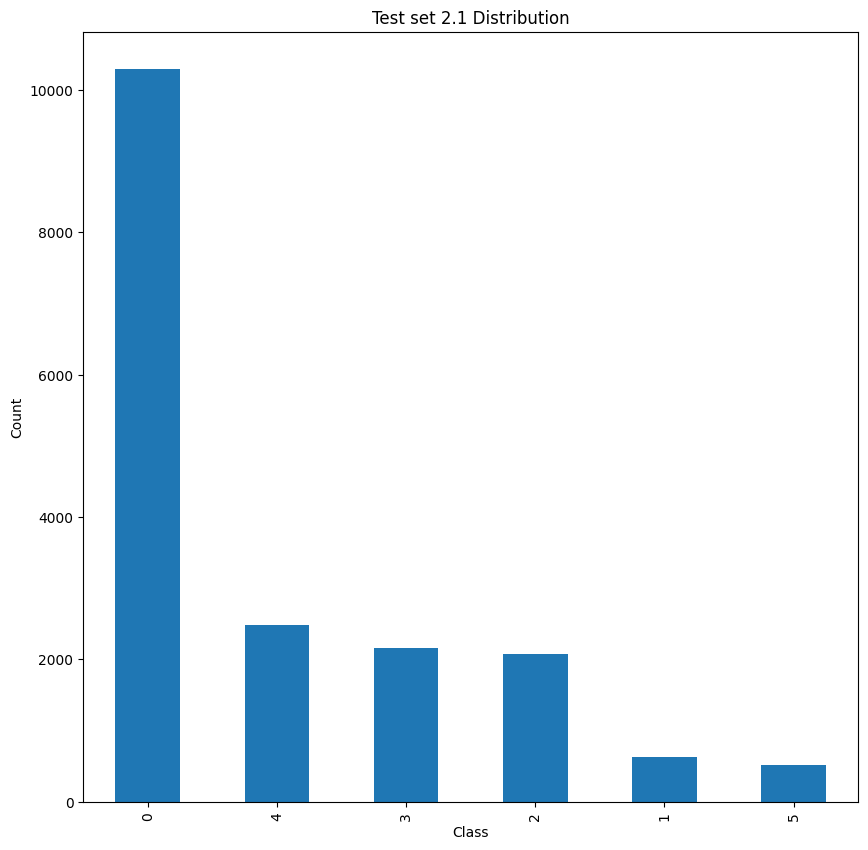

In [38]:
# plot bar chart of each class count and add number of samples in each class
test_data2['label'].value_counts().plot(kind='bar', figsize=(10, 10))   
# add title and x, y labels
plt.title('Test set 2.1 Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [39]:
test_labels2 = to_categorical(test_data2["label"], num_classes=6)

72/72 - 9s - loss: 0.1391 - accuracy: 0.9618 - 9s/epoch - 126ms/step
Test accuracy: 0.9618282914161682
Test loss: 0.13908515870571136
72/72 [==============================] - 9s 118ms/step
[[10157   115     2    14     7     5]
 [  164   438     7     4    19     2]
 [   19    20  2031     3     2     1]
 [   36     4     1  2074     2    48]
 [   42    42     1     2  2402     1]
 [  104    10     0    17     0   385]]


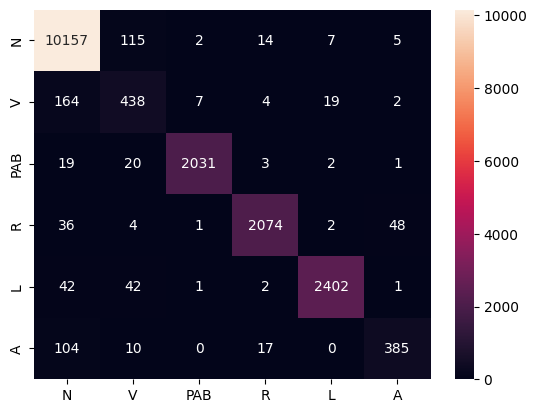

In [40]:
# test model
test_loss2, test_acc2 = model.evaluate(test_gen2, verbose=2)
print("Test accuracy:", test_acc2)
print("Test loss:", test_loss2)

# print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred2 = model.predict(test_gen2)
y_pred2 = np.argmax(y_pred2, axis=1)
y_true2 = np.argmax(test_labels2, axis=1)
cm = confusion_matrix(y_true2, y_pred2)
print(cm)
sns.heatmap(cm, annot=True, xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(), fmt="d")
plt.show()



In [41]:
# print classification report
from sklearn.metrics import classification_report
print(classification_report(y_true2, y_pred2))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     10300
           1       0.70      0.69      0.69       634
           2       0.99      0.98      0.99      2076
           3       0.98      0.96      0.97      2165
           4       0.99      0.96      0.98      2490
           5       0.87      0.75      0.80       516

    accuracy                           0.96     18181
   macro avg       0.92      0.89      0.90     18181
weighted avg       0.96      0.96      0.96     18181



In [42]:
test_data2['label'].value_counts()


0    10300
4     2490
3     2165
2     2076
1      634
5      516
Name: label, dtype: int64